In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [59]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [61]:
!wget -O sam_vit_l.pth "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth"

--2025-03-17 17:33:46--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.172.185.63, 18.172.185.43, 18.172.185.67, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.172.185.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [binary/octet-stream]
Saving to: ‘sam_vit_l.pth’

sam_vit_l.pth       100%[===================>]   1.16G  63.1MB/s    in 20s     

2025-03-17 17:34:06 (58.9 MB/s) - ‘sam_vit_l.pth’ saved [1249524607/1249524607]



In [63]:
!pip install torch torchvision torchaudio opencv-python matplotlib segment-anything

In [62]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [64]:
using_colab = False

In [65]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [67]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [68]:
image = cv2.imread('/content/33-5-_jpg.rf.12f263df6f74ebfb36c5c84d4c315a81.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

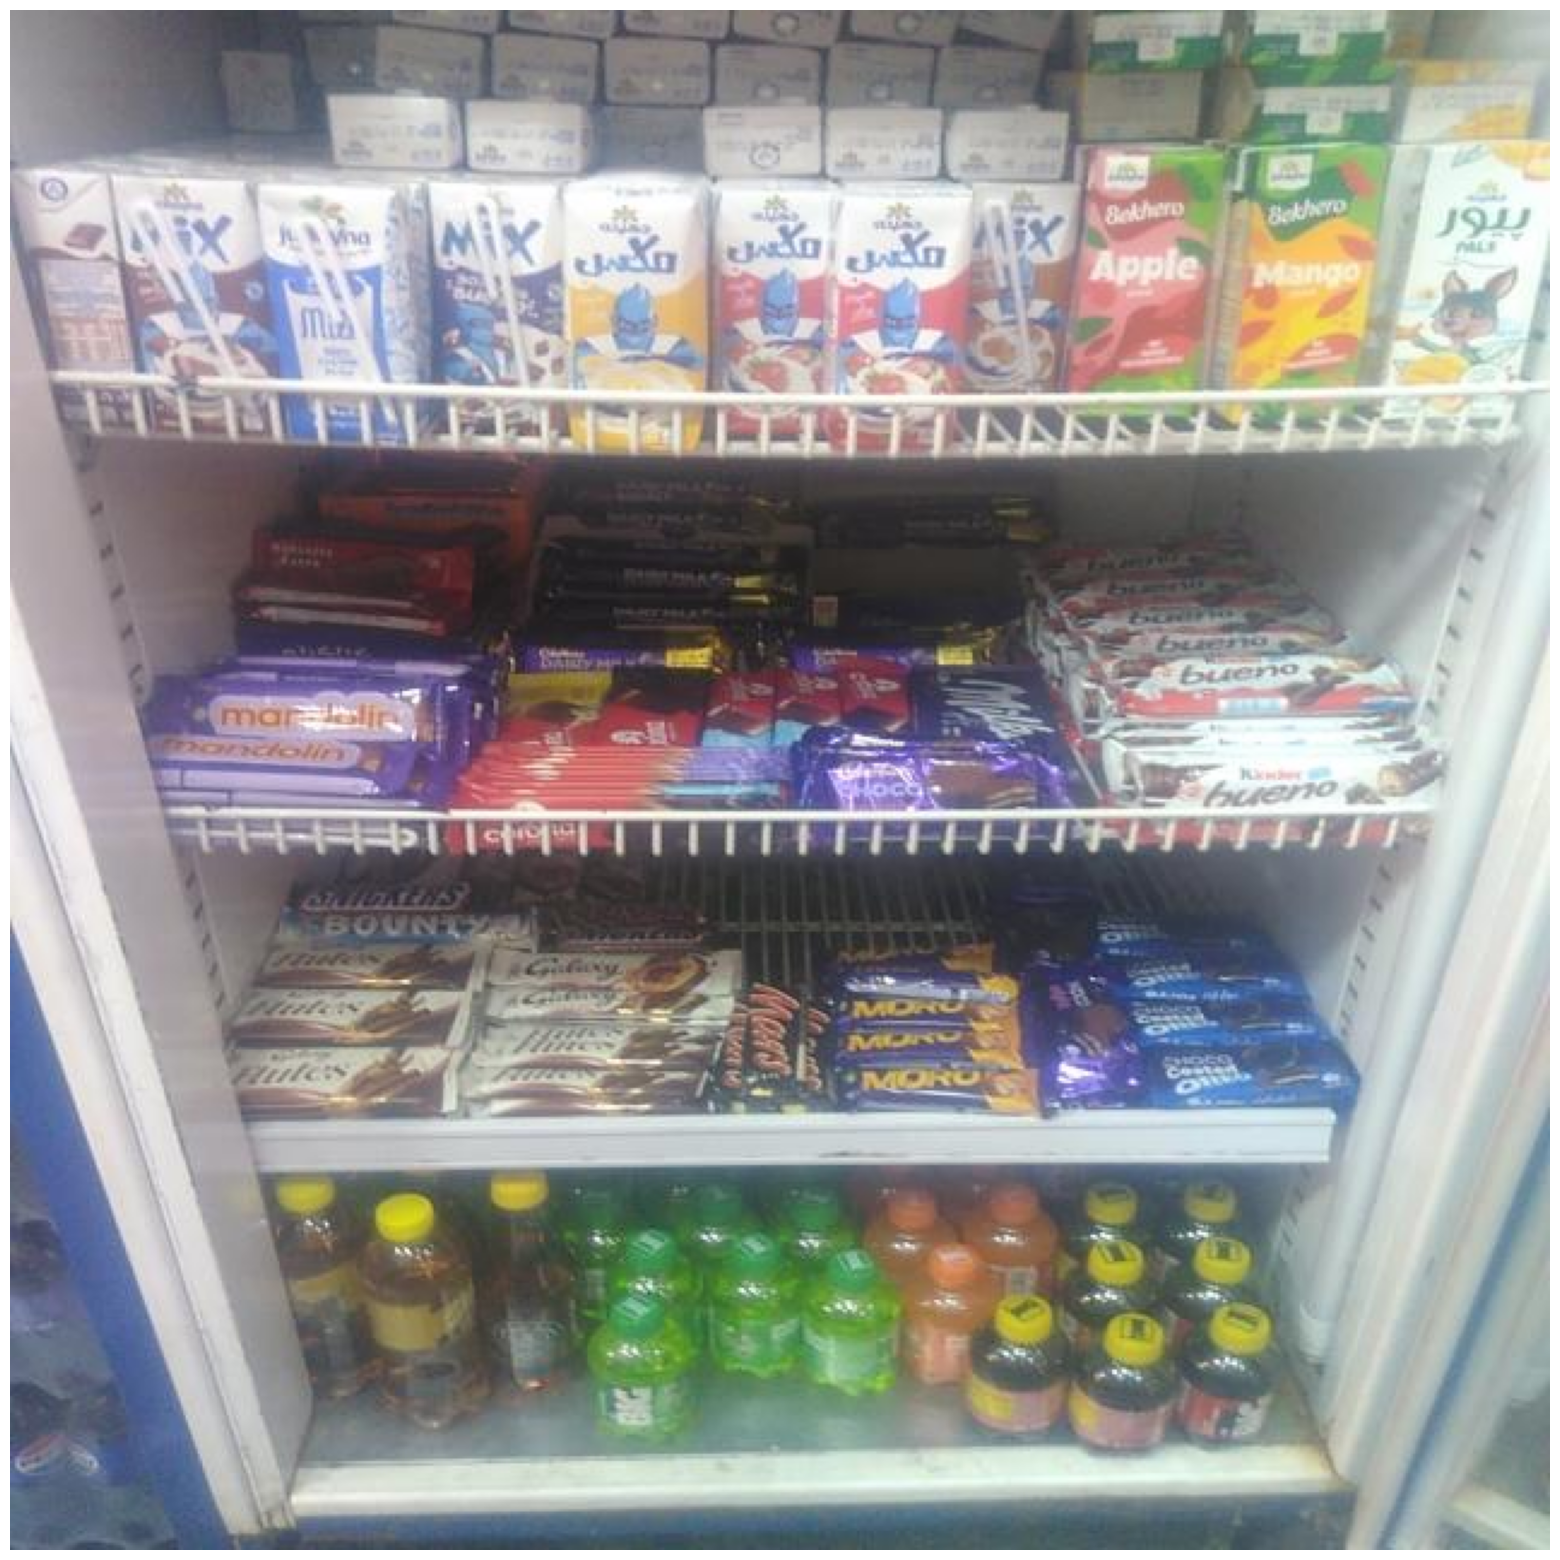

In [69]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [70]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/sam_vit_l.pth"
model_type = "vit_l"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [71]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [72]:
print(len(masks))
print(masks[0].keys())

182
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

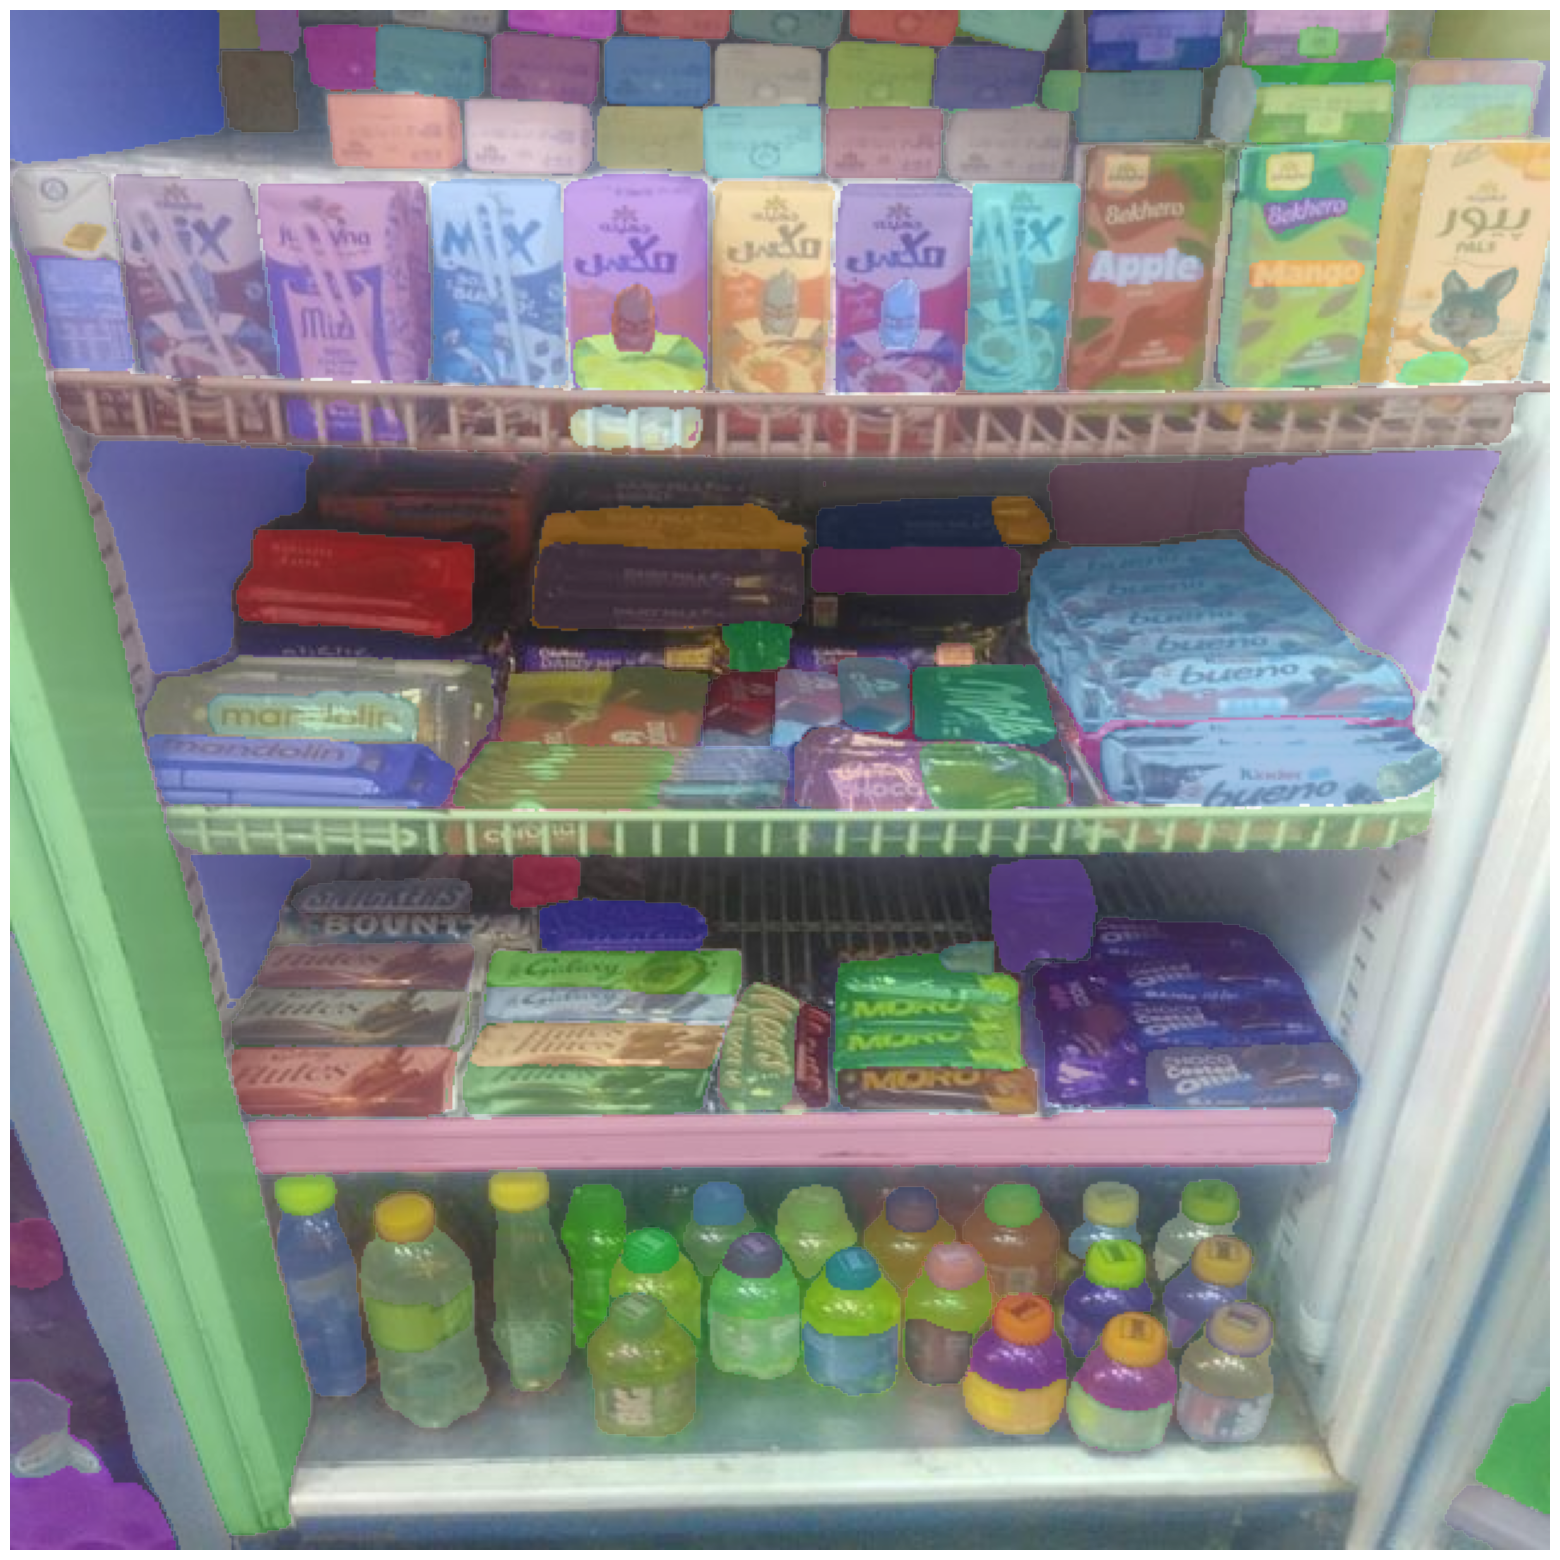

In [73]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [74]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [75]:
masks2 = mask_generator_2.generate(image)

In [76]:
len(masks2)

274

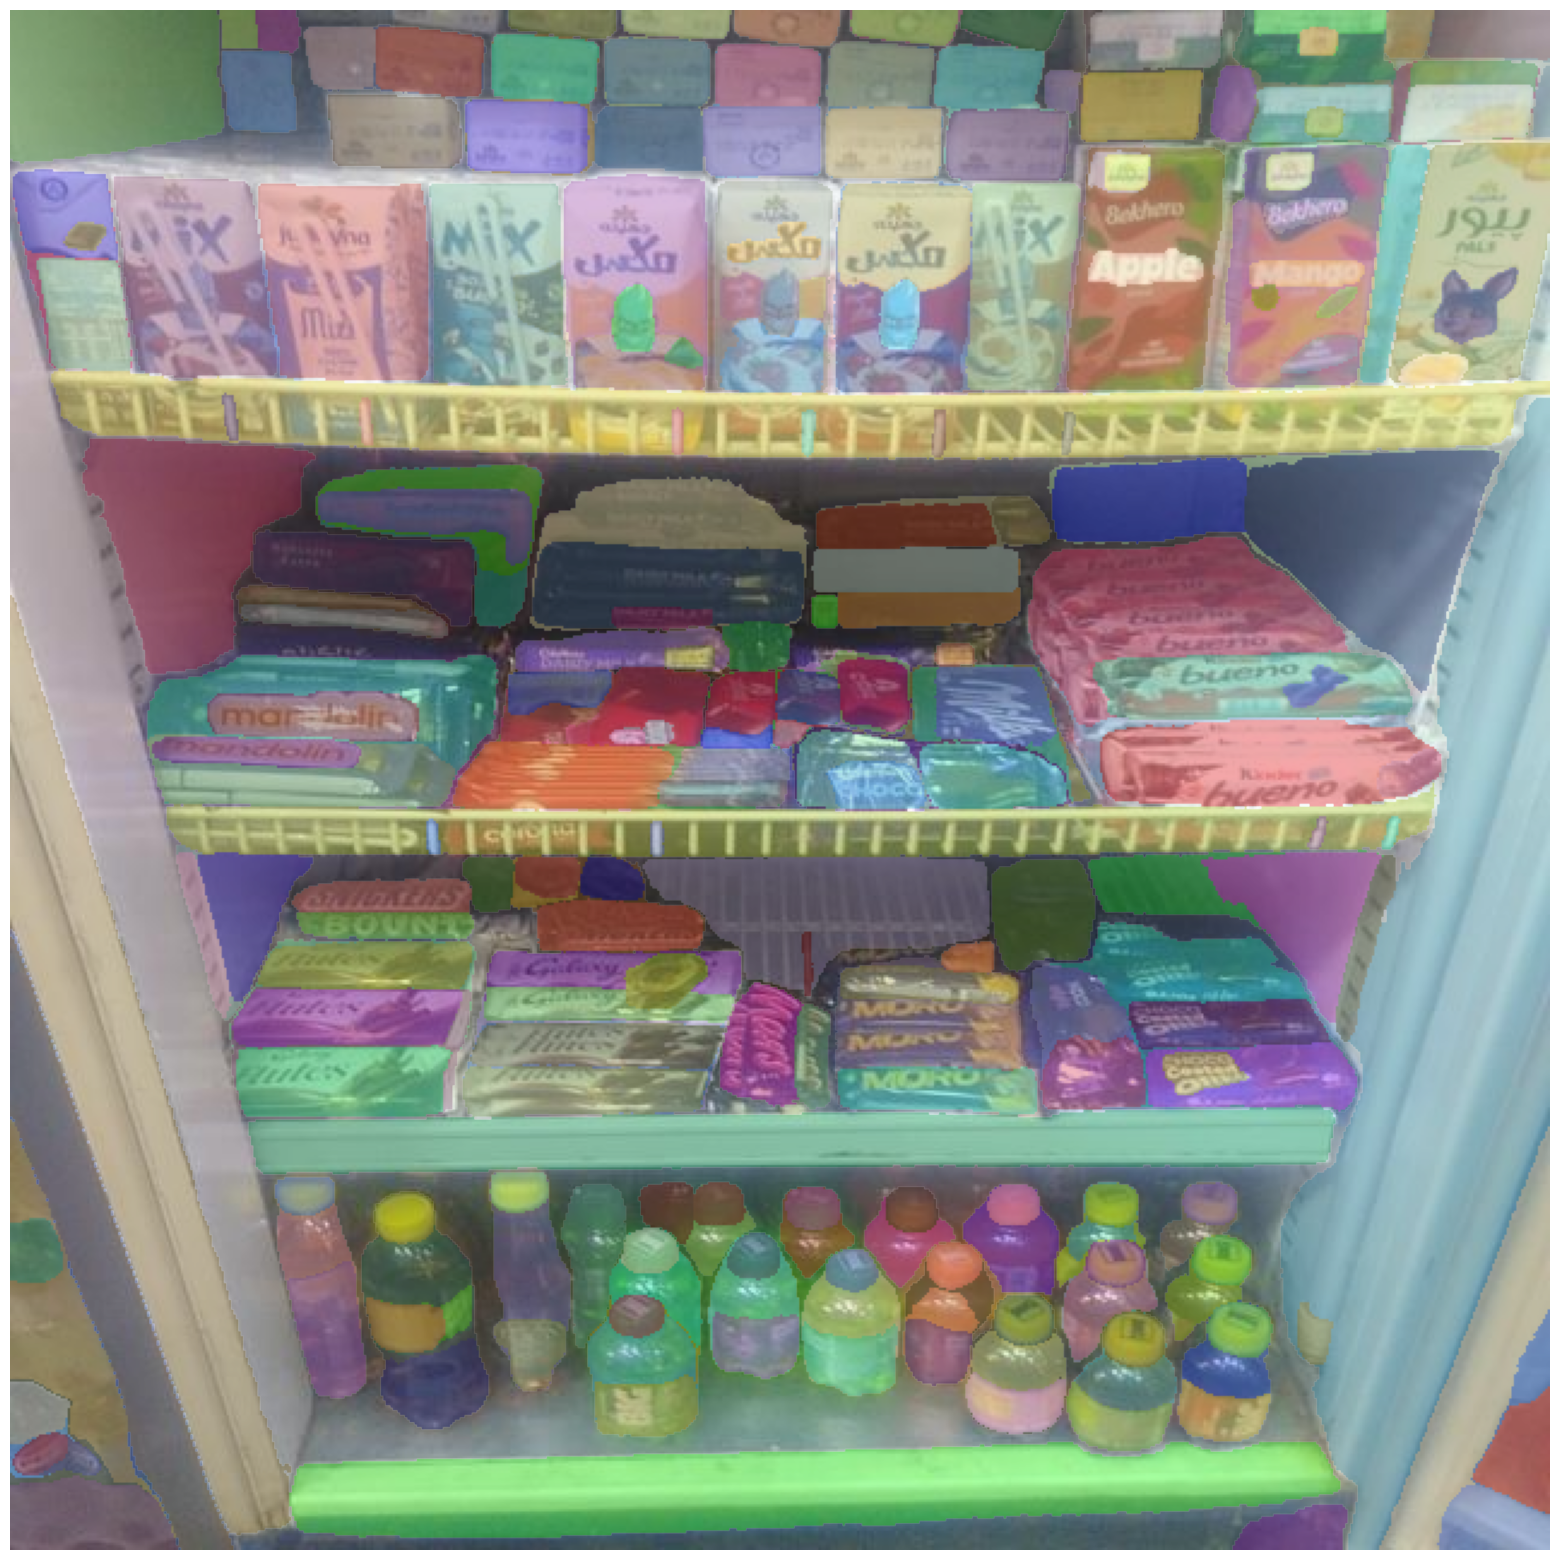

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [79]:
import random
import os
import pickle
# Select up to 5 random objects
num_masks = min(len(masks), len(masks))  # Ensure we don't exceed available masks
selected_masks = random.sample(masks, num_masks)

# Create output folder
output_folder = "extracted_objects"
os.makedirs(output_folder, exist_ok=True)

# Dictionary to store pixel data for image search
image_data = {}

for i, mask_data in enumerate(selected_masks):
    mask = mask_data["segmentation"].astype(np.uint8) * 255  # Convert mask to binary

    # Create a white background
    white_bg = np.ones_like(image) * 255

    # Extract the object and place it on the white background
    cutout = cv2.bitwise_and(image, image, mask=mask)
    white_bg[mask > 0] = cutout[mask > 0]  # Replace white background with object

    # Save the object as an image
    output_path = os.path.join(output_folder, f"object_{i+1}.png")
    cv2.imwrite(output_path, cv2.cvtColor(white_bg, cv2.COLOR_RGB2BGR))

    # Save pixel data for image search
    image_data[f"object_{i+1}"] = white_bg

# Save pixel data as a pickle file for later search
with open("object_pixels.pkl", "wb") as f:
    pickle.dump(image_data, f)

print(f"✅ Extracted {num_masks} objects and saved in '{output_folder}'")
print("✅ Pixel data saved in 'object_pixels.pkl' for image search.")

✅ Extracted 182 objects and saved in 'extracted_objects'
✅ Pixel data saved in 'object_pixels.pkl' for image search.
